In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir
import tracefc.io.traceio as traceio

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Finn', 'recall1'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 4002.59 seconds 
duration: 1.11 hours 



## Save notebook to animal working directory

In [5]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Sync_USV_and_Ephys_archive.ipynb saved to /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_Sync_USV_and_Ephys_archive.ipynb


### Load in disconnect and motion artifacts

In [6]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 124.4 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,24.0672,25.9024,None,1.8352
1,91.8944,123.9360,None,32.0416
2,131.7952,132.6608,None,0.8656
3,144.3256,151.7920,None,7.4664
4,203.8240,210.6336,None,6.8096
5,211.3012,211.8252,None,0.5240
6,218.6744,222.6064,None,3.9320
7,259.6192,260.7936,None,1.1744
8,272.0784,272.3000,None,0.2216
9,272.8732,273.2140,None,0.3408


<Axes: >

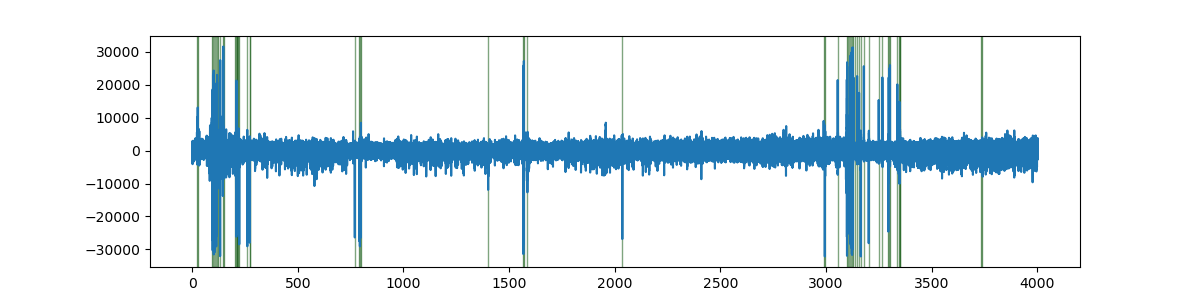

In [7]:
%matplotlib widget

chan_plot = 28
plot_signal_w_epochs(signal, 28, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.probegroup.npy saved


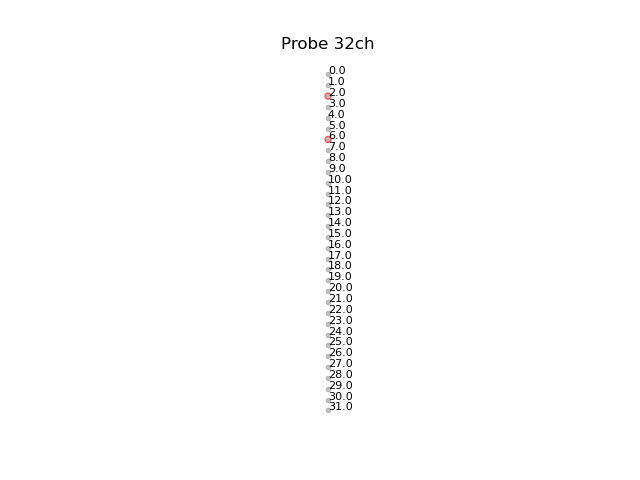

In [8]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [9]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 25

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [25]
313 epochs remaining with durations within (1,20)


## Detect SWR Epochs

In [10]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 25
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [25]
1869 epochs remaining with durations within (0.05,0.45)


## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
633,2,3817174,2022-01-21 12:39:00.239133333,
634,-2,4114849,2022-01-21 12:39:10.161633333,
828,2,6215216,2022-01-21 12:40:20.173866667,
977,-2,6513350,2022-01-21 12:40:30.111666667,
1779,2,8133652,2022-01-21 12:41:24.121733333,


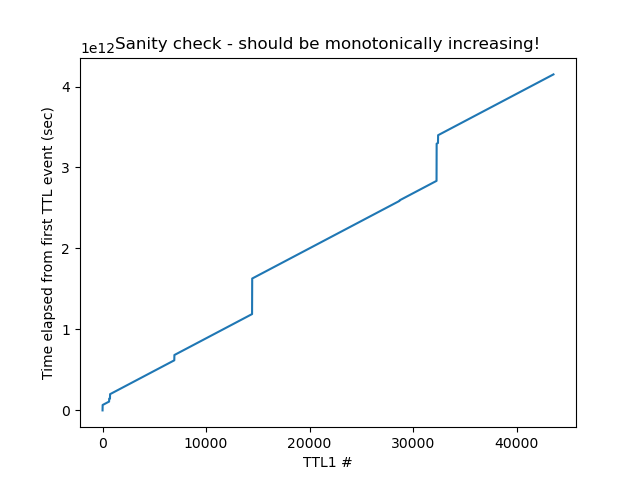

In [11]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [12]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

15 CS+ events detected
      Time (s)      Event                     Timestamp
9    60.992706  CS1_start 2022-01-21 12:39:00.826961060
11  140.927233  CS2_start 2022-01-21 12:40:20.761488219
13  204.874969  CS3_start 2022-01-21 12:41:24.709224482
15  264.824631  CS4_start 2022-01-21 12:42:24.658886214
17  325.753973  CS5_start 2022-01-21 12:43:25.588227530
19  388.704585  CS6_start 2022-01-21 12:44:28.538840314
12 CS- events detected
      Time (s)      Event                     Timestamp
5    60.840526  CS1_start 2022-01-21 13:05:10.721559627
7   128.764897  CS2_start 2022-01-21 13:06:18.645930870
9   194.714935  CS3_start 2022-01-21 13:07:24.595968587
11  261.665613  CS4_start 2022-01-21 13:08:31.546646936
13  337.597110  CS5_start 2022-01-21 13:09:47.478144033
15  404.545281  CS6_start 2022-01-21 13:10:54.426315410


In [13]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-01-21 12:30:50.731508-05:00
start time = 2022-01-21 12:30:50.731508-05:00
Dropping last 7424 frames per dropped_end_frames.txt file
start time = 2022-01-21 12:36:53.592984-05:00
start time = 2022-01-21 12:59:46.424053-05:00
start time = 2022-01-21 13:28:32.606720-05:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-01-21 12:30:50.731508-05:00,start,0,0.000000,0,0.0000
1,0,2022-01-21 12:32:49.541074667-05:00,stop,3564287,118.809567,148511,118.8088
2,1,2022-01-21 12:34:38.989641333-05:00,start,3564288,118.809600,148512,118.8096
3,1,2022-01-21 12:35:11.074941333-05:00,stop,4526847,150.894900,188618,150.8944
4,2,2022-01-21 12:36:53.592984-05:00,start,4526848,150.894933,188619,150.8952
5,2,2022-01-21 12:57:43.478817333-05:00,stop,42023423,1400.780767,1750975,1400.7800
6,3,2022-01-21 12:59:46.424053-05:00,start,42023424,1400.780800,1750976,1400.7808
7,3,2022-01-21 13:24:41.139753-05:00,stop,86864895,2895.496500,3619370,2895.4960
8,4,2022-01-21 13:28:32.606720-05:00,start,86864896,2895.496533,3619371,2895.4968
9,4,2022-01-21 13:46:59.704286667-05:00,stop,120077823,4002.594100,5003242,4002.5936


In [14]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.5872398221333335, std = 0.0013713736007565883
start time lag: mean = -0.5887733233999999, std = 0.00013625709196786435
start time lag: mean = -0.4215331420000001, std = 0.00017972138044762675
start time lag: mean = -0.4226918540833333, std = 0.00013141926171571328


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


### How to write CS+ to neuroscope event file

In [15]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

In [16]:
cs_tone_recall_epochs

15 epochs
Snippet: 
         start        stop label
0  277.541349  287.463849   CS+
1  357.476082  367.413882   CS+
2  421.423949  431.363949   CS+
3  481.373649  491.293416   CS+
4  542.302849  552.243582   CS+

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/1_tone_recall/new_arena/T0000001.WAV
Mean start lag time of -185.634 sec with std = 0.041 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of -185.922 sec with std = 0.045 sec.


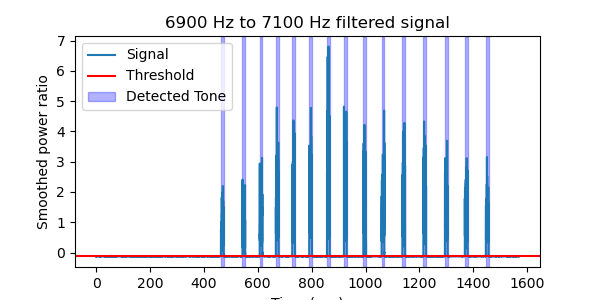

In [17]:
# Detect CS+ in audio recording.
tone_recall_wav = sorted((sess.basepath / "1_tone_recall").glob("**/*.WAV"))[0]
print(tone_recall_wav)

# Get CS+ times and plot to check
cs_wav_epochs = detect_tone(tone_recall_wav, freq_lims=(6900, 7100), thresh=-0.1, tone_length=10, tone_label="CS+", plot_check=True)

# Check that lags are consistent
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/2_control_tone_recall/new_arena2/T0000002.WAV
Mean start lag time of 1468.557 sec with std = 0.035 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 1468.264 sec with std = 0.063 sec.


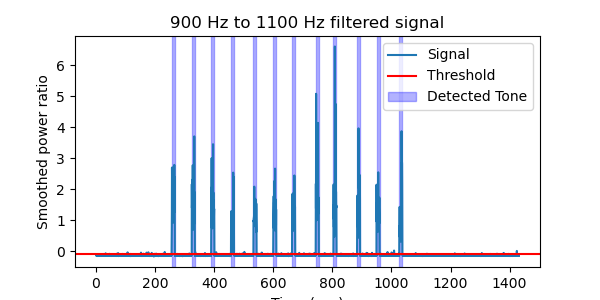

In [18]:
# Detect CS- in audio recording.
control_tone_recall_wav = sorted((sess.basepath / "2_control_tone_recall").glob("**/*.WAV"))[0]
print(control_tone_recall_wav)

# Get CS+ times and plot to check
csn_wav_epochs = detect_tone(control_tone_recall_wav, freq_lims=(900, 1100), thresh=-0.1, tone_length=10, tone_label="CS-", plot_check=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/3_ctx_recall/shock_box/T0000001.WAV


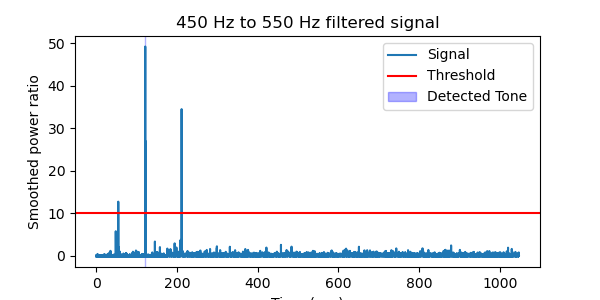

In [19]:
ctx_recall_wav = sorted((sess.basepath / "3_ctx_recall").glob("**/*.WAV"))[0]
print(ctx_recall_wav)

# Get CS+ times and plot to check
start_wav_epochs = detect_tone(ctx_recall_wav, freq_lims=(450, 550), thresh=10, tone_length=0.5, tone_label="start_tone", plot_check=True)

## Sync recorded USV times to ephys file

In [20]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
usv_detect_file = sorted(tone_recall_wav.parent.glob(f"**/{tone_recall_wav.name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
0,463.540248,18.375000,3.390000,6.125000,0.538919,0
1,467.582820,18.375000,5.550000,6.125000,0.621996,0
2,607.828336,18.625000,3.370000,5.750000,0.587801,0
3,611.814908,18.500000,5.230000,6.000000,0.561026,0
4,666.988720,18.500000,5.370000,6.000000,0.592376,0
...,...,...,...,...,...,...
214,1562.019267,17.792658,1.054818,4.979317,1.000000,1
215,1563.205016,16.686143,0.851456,6.307135,1.000000,1
216,1564.171144,18.567218,0.892067,4.979317,1.000000,1
217,1565.171306,15.911582,0.602594,9.294726,1.000000,1


Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

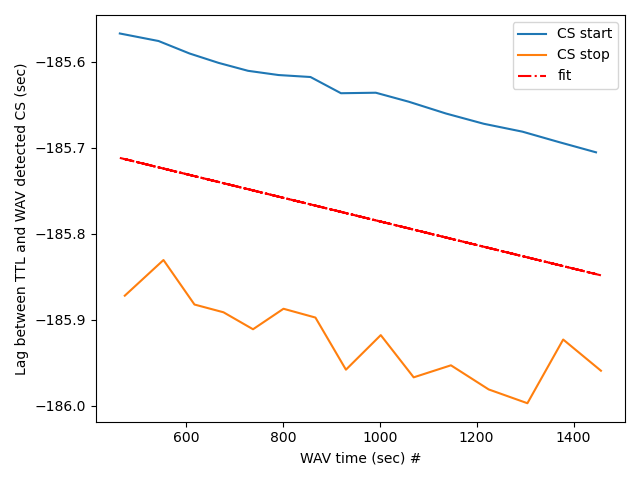

In [21]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb)
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [22]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_starts_aligned = cs_wav_epochs.starts + p[0] + p[1]*cs_wav_epochs.starts
cs_wav_stops_aligned = cs_wav_epochs.stops + p[0] + p[1]*cs_wav_epochs.stops
cs_wav_epochs_aligned = Epoch({"start": cs_wav_starts_aligned, "stop": cs_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(cs_wav_stops_aligned)})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.cs_wav_epochs.npy saved


In [23]:
cs_wav_epochs_aligned

15 epochs
Snippet: 
         start        stop              label
0  277.396747  287.622589  CS+ from WAV file
1  357.329247  367.520207  CS+ from WAV file
2  421.282820  431.513212  CS+ from WAV file
3  481.235200  491.443461  CS+ from WAV file
4  542.165256  552.404972  CS+ from WAV file

Now correct that drift and find corrected lags!

In [24]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.usv_epochs.npy saved


/data/GitHub/NeuroPy/neuropy/core/epoch.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epochs.loc[:, "label"] = epochs["label"].astype("str")


In [25]:
good_calls

203 epochs
Snippet: 
          start         stop   Begin_Time  Freq_Min  Duration  Freq_Range  \
0  1016.930199  1019.321947  1202.743826    15.750  2.392077         6.5   
1  1021.038342  1022.978082  1206.852534    15.625  1.940006         5.5   
2  1023.171727  1024.560180  1208.986212    16.000  1.388644         7.0   
3  1024.772570  1026.313028  1210.587275    16.000  1.540670         7.0   
4  1026.491271  1027.771154  1212.306212    16.000  1.280059         7.0   

      Score  Accept label  
0  0.555882       1        
1  0.574933       1        
2  0.589289       1        
3  0.589289       1        
4  0.589289       1        

## Save notebook to working directory

In [26]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)